In [1]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import time

In [2]:
import ipynb.fs.full.utils as utils
import ipynb.fs.full.dataloader as dataloader
import ipynb.fs.full.network as network

110


In [3]:
BATCH_SIZE = 8
SUBSAMPLE_SIZE = 2500
SETS = 4
EPOCHS = 20
IN_FEATURES = dataloader.get_num_features() 
LAYER_SIZES = [20, 20, 20, 20, 2]
LR = .001
LR_DECAY= 1e-7
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = network.Network(IN_FEATURES, LAYER_SIZES) 
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()
optimizer = torch.optim.Adagrad(
        model.parameters(), 
        lr=LR, 
        lr_decay=LR_DECAY
       )

In [4]:
def get_num_correct(output, labels):
    output_softmax = nn.functional.softmax(output, dim = 1)
    pred = torch.argmax(output_softmax, dim=1)
    return np.sum(np.array(pred)== np.array(labels))

def train(train_loader, dataset_length, log_tensorboard=False):
    training_losses = []
    training_accuracies = []
    for epoch in range(EPOCHS):
        ts = time.time()
        losses = []
        total_correct = 0
        for iter, (inputs, labels) in enumerate(train_loader):
            ## need to debug all outputs are zero
            # reset optimizer gradients
            optimizer.zero_grad()

            # send inputs and labels to the same device
            inputs = inputs.type(torch.FloatTensor).to(DEVICE)
            labels = labels.type(torch.FloatTensor).to(DEVICE)
            model.to(DEVICE)

            writer.add_graph(model, inputs)

            outputs = model(inputs)

            outputs = outputs.type(torch.FloatTensor).to(DEVICE)
            labels = labels.type(torch.LongTensor).to(DEVICE)

            loss = criterion(outputs, labels)
            losses.append(loss.item())
            total_correct += get_num_correct(outputs, labels)
            
            if log_tensorboard:
                writer.add_scalar("Batch Loss", loss.item(), iter)

            #backprop
            loss.backward()

            # update weights
            optimizer.step()

            if iter % 150 == 0:
                print("epoch: {}, iter: {}, loss: {}".format(epoch, iter, loss.item()))

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        average_loss = np.mean(np.array(losses))
        accuracy = total_correct/dataset_length

        if log_tensorboard:
            writer.add_scalar("Loss/train", average_loss, epoch)
            writer.add_scalar("Correct", total_correct, epoch)
            writer.add_scalar("Accuracy", accuracy, epoch)

        training_losses.append(average_loss)
        training_accuracies.append(accuracy)

    return training_losses, training_accuracies

In [5]:
datasets = dataloader.get_datasets(SUBSAMPLE_SIZE, SETS)
dataloaders = dataloader.get_loaders(
        datasets,
        BATCH_SIZE 
        )

d1 = datasets[0]
# might be able to get the length of the dataset
# from the loader
d1_loader = dataloaders[0]

training_losses, training_accuracies = train(
        d1_loader, 
        dataset_length=len(d1),
        log_tensorboard=False
        )
writer.flush()
writer.close()

epoch: 0, iter: 0, loss: 0.6399247050285339
epoch: 0, iter: 150, loss: 0.8540658950805664
epoch: 0, iter: 300, loss: 0.8546381592750549
Finish epoch 0, time elapsed 5.680239915847778
epoch: 1, iter: 0, loss: 0.562335729598999
epoch: 1, iter: 150, loss: 0.8505533933639526
epoch: 1, iter: 300, loss: 0.8486160039901733
Finish epoch 1, time elapsed 5.5782599449157715
epoch: 2, iter: 0, loss: 0.5623401403427124
epoch: 2, iter: 150, loss: 0.8480352163314819
epoch: 2, iter: 300, loss: 0.8431487083435059
Finish epoch 2, time elapsed 5.516380786895752
epoch: 3, iter: 0, loss: 0.5623412132263184
epoch: 3, iter: 150, loss: 0.846619188785553
epoch: 3, iter: 300, loss: 0.838441014289856
Finish epoch 3, time elapsed 5.600219249725342
epoch: 4, iter: 0, loss: 0.5623416900634766
epoch: 4, iter: 150, loss: 0.8457176685333252
epoch: 4, iter: 300, loss: 0.834279477596283
Finish epoch 4, time elapsed 5.620362758636475
epoch: 5, iter: 0, loss: 0.5623420476913452
epoch: 5, iter: 150, loss: 0.845089912414550

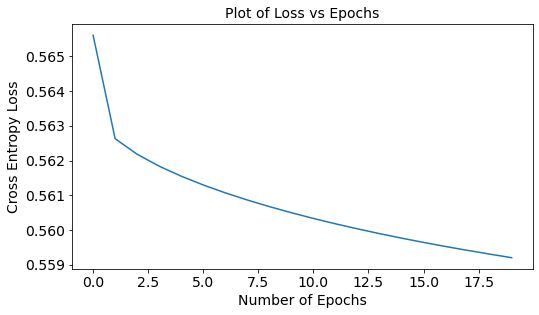

In [6]:
utils.plot_losses(training_losses)

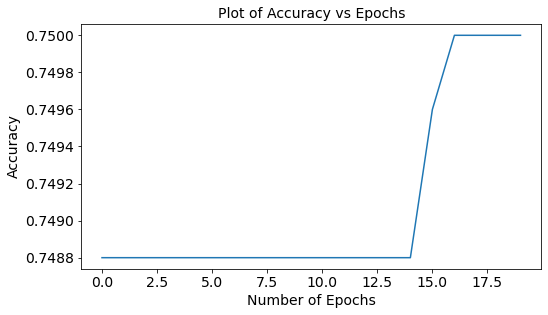

In [7]:
utils.plot_accuracies(training_accuracies)

In [8]:
# In the Paper they achieve average .85 training accuracy. 
# I have not tuned any hyperparameters
print("Final Training Accuracy for one run")
print(training_accuracies[-1])

Final Training Accuracy for one run
0.75
